In [206]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import yaml
import json
import sys

sys.path.append('..')
sys.path.append('../diploma_thesis/')

from environment import Statistics
from utils import *

plt.style.use('seaborn-v0_8-paper')

In [3]:
%load_ext autoreload
%autoreload 2

# Util

In [4]:
def get_parameters(path: str):
    parameters_path = os.path.join(path, 'parameters.yml')

    with open(parameters_path) as f:
        parameters = yaml.safe_load(f)

    return parameters

In [111]:
def filter_models(dataset, predicate):
    result = []

    for directory in os.listdir(dataset):
        directory_path = os.path.join(dataset, directory)

        if not os.path.isdir(directory_path):
            continue

        parameters = get_parameters(directory_path)

        if predicate(parameters):
            result += [directory]

    return result

def filter_by_mod(parameters, predicate):
    mods = parameters['machine_agent']['parameters']['mods']

    for mod in mods:
        if predicate(mod):
            return True

    return False

# JSP

In [7]:
dataset = '../diploma_thesis/results/jsp/marl_direct'

## Training

In [37]:
candidate_path = os.path.join(dataset, 'model_321')

In [38]:
agent_path = os.path.join(candidate_path, 'agent')

### Parameters

In [39]:
parameters = get_parameters(candidate_path)

print(json.dumps(parameters, indent=4))

{
    "debug": false,
    "graph": {
        "transition_model": {
            "kind": "no"
        }
    },
    "log_stdout": false,
    "machine_agent": {
        "kind": "mod",
        "parameters": {
            "base_path": "configuration/mods/machine/dqn.yml",
            "mods": [
                "agent/dqn/ddqn.yml",
                "agent/dqn/dueling.yml",
                "agent/dqn/prioritized.yml",
                "agent/dqn/3_step.yml"
            ],
            "template": "marl_direct"
        }
    },
    "name": "model_321",
    "output_dir": "results/jsp/marl_direct",
    "run": {
        "kind": "mod",
        "parameters": {
            "base_path": "configuration/mods/run/run.yml",
            "mods": [
                "n_workers/4.yml",
                "timeline/warmup.yml"
            ],
            "nested": {
                "parameters": {
                    "simulations": [
                        {
                            "kind": "multi_value",
         

### Loss

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


,Unnamed: 0,value,lr
optimizer_step,,,
1,0,0.219367,0.001
2,1,0.203570,0.001
3,2,0.204720,0.001
4,3,0.226908,0.001
5,4,0.153063,0.001
...,...,...,...
2072,2071,6.066348,0.001
2073,2072,5.718666,0.001
2074,2073,4.941825,0.001


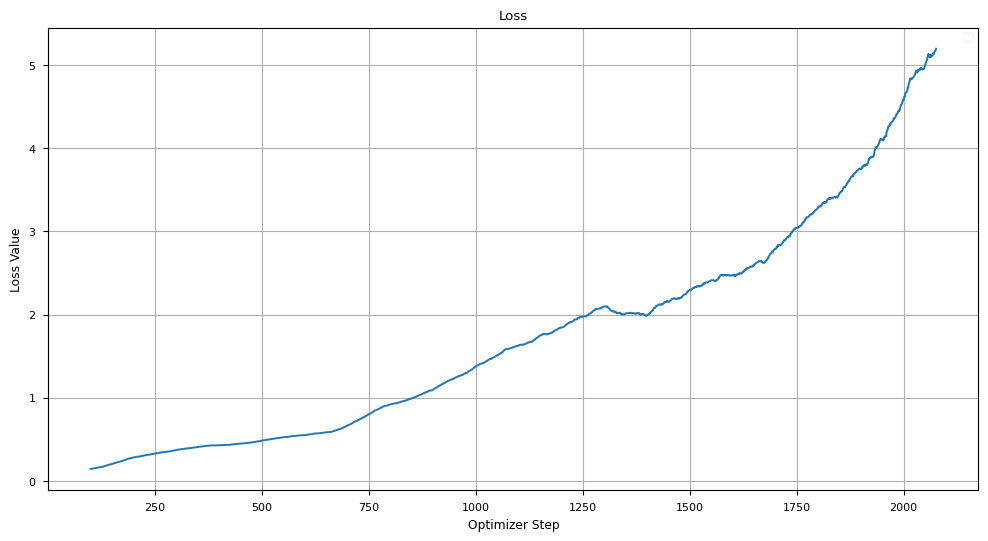

In [312]:
def smooth(x):
    return x.rolling(window=100).mean()

machine_loss = os.path.join(agent_path, 'machine_loss.csv')

fig, loss = plot_value(
    machine_loss,
    info=dict(
        column='value',
        title='Loss',
        xlabel='Optimizer Step',
        ylabel='Loss Value',
        index='optimizer_step'
    ),
    figsize=(12, 6),
    post_process_fn=smooth)

loss

### Reward

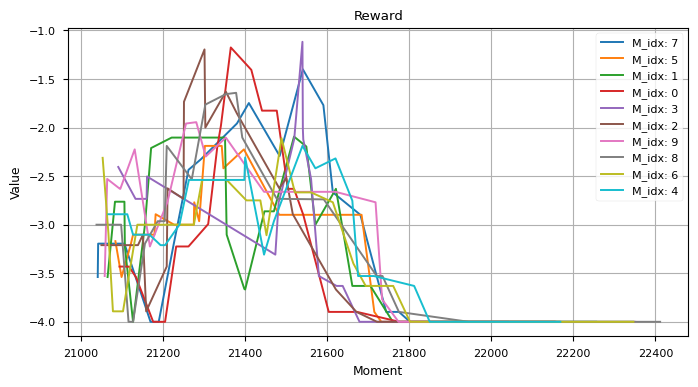

In [313]:
def sum(x):
    return x.rolling(window=4).sum()

run = '_1_79'

machine_reward = os.path.join(candidate_path, 'run', run, 'machine_reward.csv')

fig, reward = plot_value(
    machine_reward,
    info=dict(
        column='reward',
        title='Reward',
        xlabel='Moment',
        ylabel='Value',
        index='moment'
    ),
    figsize=(8, 4),
    post_process_fn=sum
)


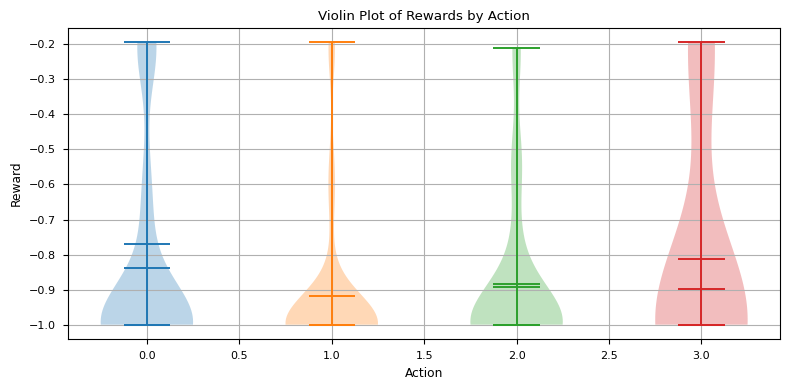

In [314]:
plot_reward_distribution_per_action(reward, figsize=(8,4));

#### Decisions per machine

In [315]:
reward

,work_center_id,action,moment,reward,machine_id,shop_floor_id
0,7,3,20981.906250,-0.538963,0,78
1,5,3,21024.906250,-0.538963,0,78
2,1,2,21065.906250,-0.538963,0,78
3,0,0,21083.906250,-0.538963,0,78
4,3,2,21133.906250,-0.538963,0,78
...,...,...,...,...,...,...
305,8,3,22411.437500,-1.000000,0,78
306,5,1,21036.906250,-1.000000,0,78
307,0,3,21094.906250,-1.000000,0,78
308,4,3,22113.412109,-1.000000,0,78


In [316]:
by_action = reward.groupby(['work_center_id', 'machine_id', 'action']).count()['shop_floor_id'].reset_index()
# by_action = by_action.rename({'shop_floor_id': 'count'}, axis=1)

by_action

,work_center_id,machine_id,action,shop_floor_id
0,0,0,0,8
1,0,0,1,2
2,0,0,2,6
3,0,0,3,15
4,1,0,0,8
5,1,0,2,16
6,1,0,3,7
7,2,0,0,6
8,2,0,1,1
9,2,0,2,11


## Tournament

In [317]:
tournament_path = '../diploma_thesis/results/tournaments/deep_marl_direct'

In [318]:
report_path = os.path.join(tournament_path, 'report.txt')

with open(report_path) as f:
    result = f.readlines()

print(''.join(result))

+----------------------------------------+---------------------+---------------------+---------------------+
|               candidate                |   makespan_reward   |  tardiness_reward   |      total_sum      |
+----------------------------------------+---------------------+---------------------+---------------------+
|  PTWINQSSchedulingRule_CTRoutingRule   | 0.6457107636379078  |  0.766756892788986  | 1.4124676564268936  |
|    MWRKSchedulingRule_CTRoutingRule    |  0.691835627600085  | 0.7154079237149851  |  1.40724355131507   |
|    MONSchedulingRule_CTRoutingRule     | 0.6637290626531467  | 0.7267385634478961  | 1.3904676261010427  |
|               _model_321               | 0.6345551194972359  | 0.7095031213391155  | 1.3440582408363513  |
|               _model_49                | 0.6172822933876887  | 0.7003718800205528  | 1.3176541734082416  |
|               _model_278               | 0.6152941664331593  | 0.6975938088764533  | 1.3128879753096125  |
|               _mo

In [319]:
result_path = os.path.join(tournament_path, 'result.csv')
results = pd.read_csv(result_path)
results['candidate'] = results['candidate'].str.lstrip('_')

In [320]:
k = 10

top_k = results.groupby(['candidate']).sum().sort_values(by=['makespan_reward'], ascending=False).head(k).reset_index()['candidate']

top_k = set(top_k)

## Reward Distribution

In [321]:
df = results[results['run'].str.contains('tailard')].copy()
df = df[df['run'].str.contains('71|72|73|74|75|76|77|78|79|80')]

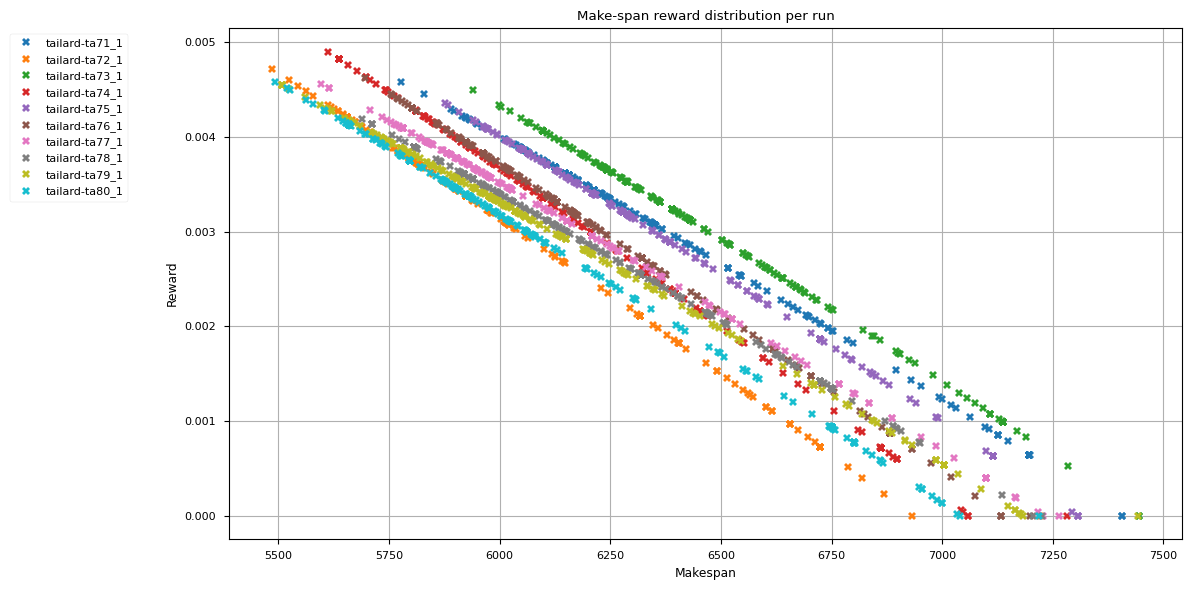

In [322]:
plot_reward_per_run(
    df,
    info=dict(
        title='Make-span reward distribution per run',
        xlabel='Makespan',
        ylabel='Reward',
        marker='X',
        metric='makespan',
        reward='makespan_reward',
        group='run',
        ncols=1,
        bbox_to_anchor=(-0.1, 1),
        figsize=(12, 6)
    ),
    format_group=lambda x: x.strip('_')
);

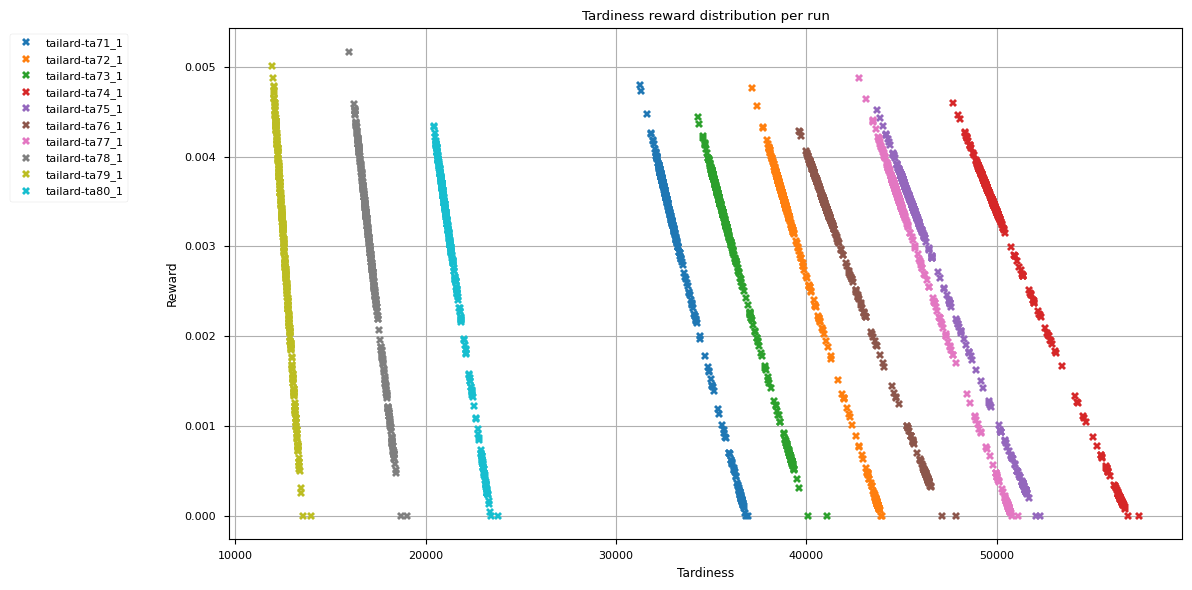

In [323]:
plot_reward_per_run(
    df,
    info=dict(
        title='Tardiness reward distribution per run',
        xlabel='Tardiness',
        ylabel='Reward',
        marker='X',
        metric='tardiness',
        reward='tardiness_reward',
        group='run',
        ncols=1,
        bbox_to_anchor=(-0.1, 1),
        figsize=(12, 6)
    ),
    format_group=lambda x: x.strip('_')
);

### Reward Distribution per model

In [324]:
df['candidate'] = df['candidate'].str.lstrip('_')

In [325]:
static_rules = list(df[~df['candidate'].str.contains('model')]['candidate'].unique())

run_filter = lambda p: True
run_filter = lambda p: p['simulator']['kind'] == 'episodic'

reward_filter = lambda p: True
reward_filter = lambda p: p['tape']['machine_reward']['kind'] == 'global_mdpi'

filter_models_ = lambda d, fn: filter_models(d, lambda p: run_filter(p) and reward_filter(p) and fn(p))

plain_dqn = filter_models_(dataset, lambda p:  len(p['machine_agent']['parameters']['mods']) == 0)

dueling_ddqn = filter_models_(
    dataset,
    lambda p: filter_by_mod(p, lambda mod: 'dueling' in mod) and
              filter_by_mod(p, lambda mod: 'ddqn' in mod) and
              not filter_by_mod(p, lambda mod: 'priori' in mod) and
              not filter_by_mod(p, lambda mod: '3_step' in mod))

dueling_ddqn_pr = filter_models_(
    dataset,
    lambda p: filter_by_mod(p, lambda mod: 'dueling' in mod) and
              filter_by_mod(p, lambda mod: 'ddqn' in mod) and
              filter_by_mod(p, lambda mod: 'priori' in mod) and
              not filter_by_mod(p, lambda mod: '3_step' in mod))

dueling_ddqn_pr_3_step = filter_models_(dataset,
                                        lambda p: filter_by_mod(p, lambda mod: 'dueling' in mod) and
                                                  filter_by_mod(p, lambda mod: 'ddqn' in mod) and
                                                  filter_by_mod(p, lambda mod: 'priori' in mod) and
                                                  filter_by_mod(p, lambda mod: '3_step' in mod))

reinforce = filter_models_(dataset, lambda p: 'reinforce' in p['machine_agent']['parameters']['base_path'])

ppo = filter_models_(dataset, lambda p: 'ppo' in p['machine_agent']['parameters']['base_path'])

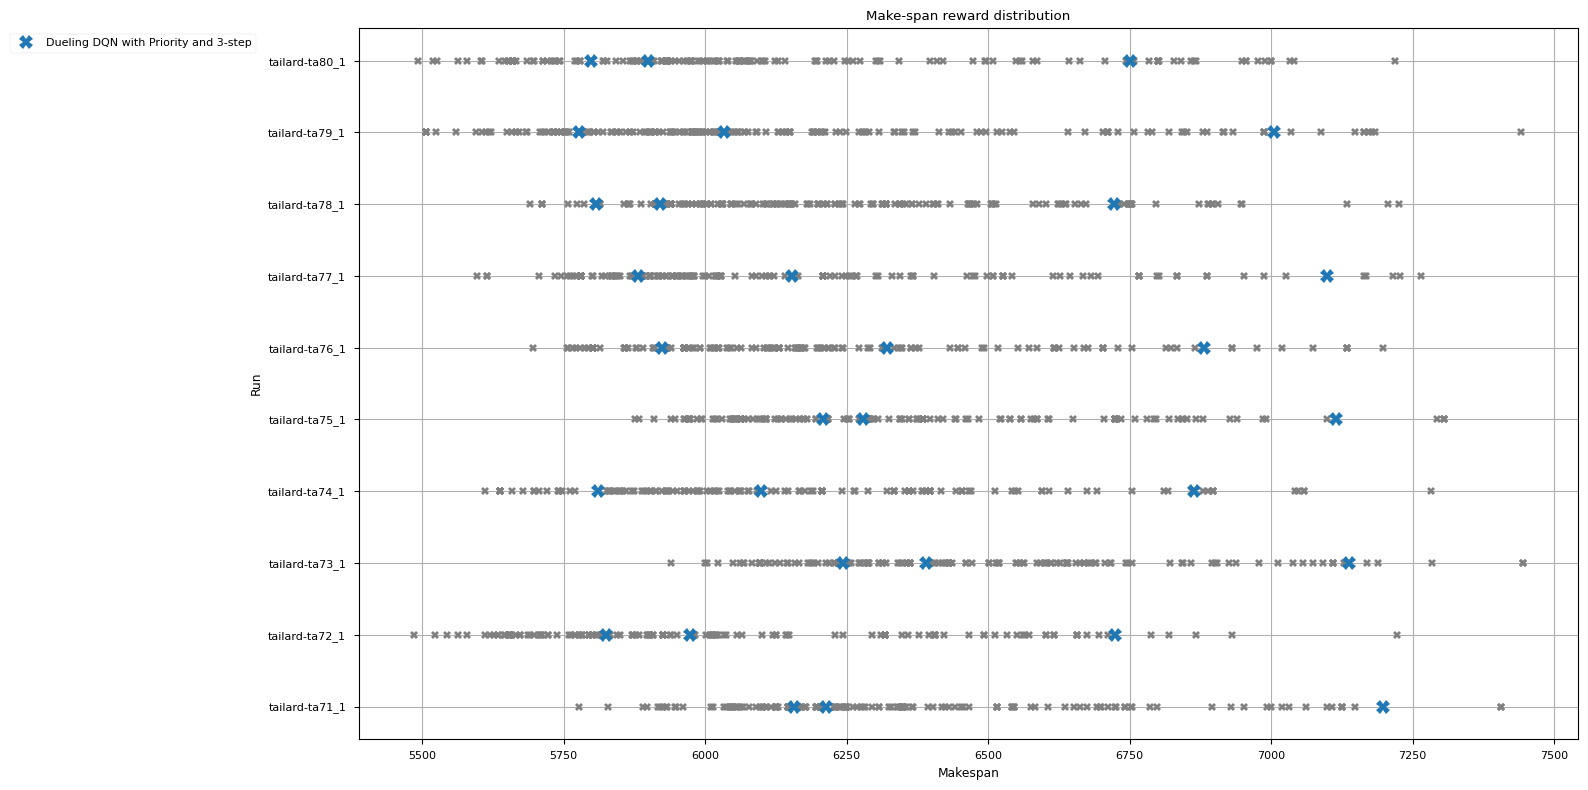

In [328]:
plot_performance_across_runs(
    df,
    info=dict(
        title='Make-span reward distribution',
        xlabel='Makespan',
        ylabel='Run',
        marker='X',
        metric='makespan',
        reward='makespan_reward',
        candidate_column='candidate',
        candidates=
        {
            # 'Static Rules': static_rules,
            # 'Plain DQN': plain_dqn,
            # 'Dueling DQN': dueling_ddqn,
            # 'Dueling DQN with Priority': dueling_ddqn_pr,
            'Dueling DQN with Priority and 3-step': dueling_ddqn_pr_3_step,
            # 'REINFORCE': reinforce,
            # 'PPO': ppo
        },
        group='run',
        ncols=1,
        figsize=(16, 8)
    )
);

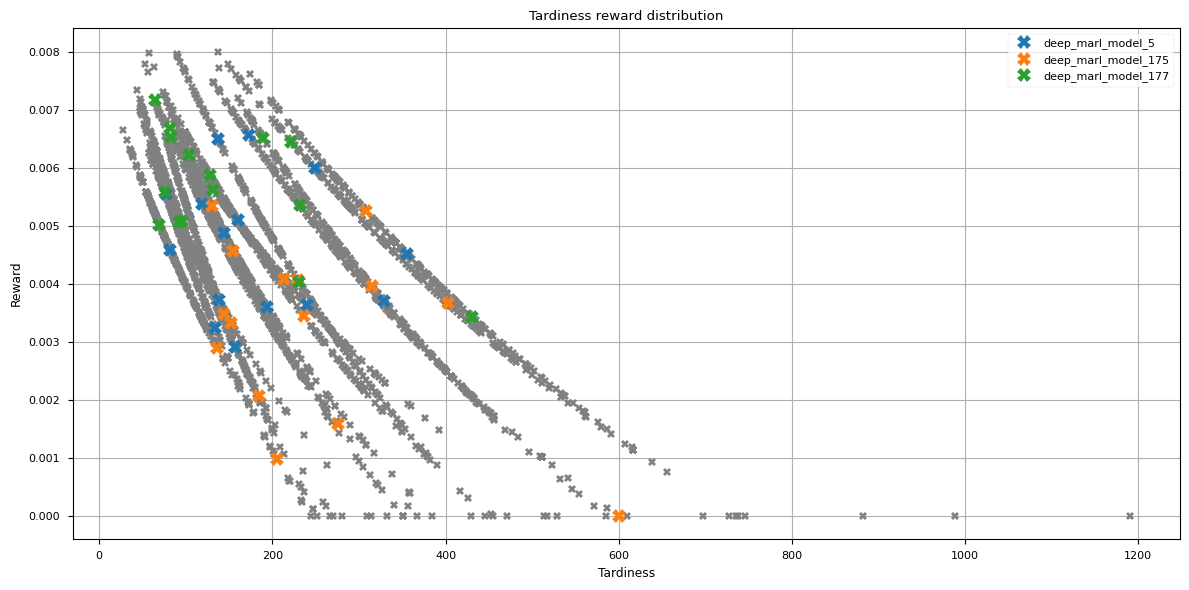

In [318]:
plot_reward_per_model_across_runs(
    results,
    info=dict(
        title='Tardiness reward distribution',
        xlabel='Tardiness',
        ylabel='Reward',
        marker='X',
        metric='tardiness',
        reward='tardiness_reward',
        candidate_column='candidate',
        candidates=models,
        group='run'
    )
);

#### Analyze results

In [23]:
reward_columns = [column for column in results.columns if 'reward' in column ]

results_per_candidate = results.copy()

results_per_candidate = results_per_candidate[['candidate', *reward_columns]].groupby(['candidate']).sum()
results_per_candidate['reward'] = 0

for column in reward_columns:
    results_per_candidate['reward'] += results_per_candidate[column]

results_per_candidate = results_per_candidate.sort_values(by=['reward'], ascending=False).reset_index()

results_per_candidate

,candidate,makespan_reward,tardiness_reward,reward
0,deep_marl_model_123,0.083460,0.079801,0.163262
1,deep_marl_model_78,0.075077,0.082871,0.157949
2,deep_marl_model_137,0.084218,0.073722,0.157940
3,deep_marl_model_89,0.077012,0.079193,0.156206
4,DPTWINQNPTSchedulingRule_CTRoutingRule,0.078611,0.076391,0.155002
...,...,...,...,...
217,FIFOSchedulingRule_CTRoutingRule,0.068385,0.036169,0.104554
218,LIFOSchedulingRule_CTRoutingRule,0.057569,0.039906,0.097476
219,LROSchedulingRule_CTRoutingRule,0.047264,0.049595,0.096859
220,NPTSchedulingRule_CTRoutingRule,0.055071,0.036829,0.091900


In [24]:
models = filter_models(dataset, lambda parameters: filter_by_mod(parameters, lambda mod: 'priori' in mod))

In [25]:
len(models)

96

In [26]:
candidates = results_per_candidate[results_per_candidate['candidate'].isin(models)]

candidates

,candidate,makespan_reward,tardiness_reward,reward


## Simulation Analysis

#### Utils

#### Main

In [262]:
run_path = '../diploma_thesis/tmp/test/run/_1/'

In [263]:
statistics = Statistics.load(run_path)

In [264]:
statistics.shop_floor_history.jobs[1].history.started_at

tensor([  0, 126, 218, 264, 295, 330, 350, 451, 503])

In [265]:
print(statistics.report())

+----+------------------------+--------------+------------------+------------+-------------+-------------+--------------+-------------+
|    | weighted_by_priority   |   total_jobs |   completed_jobs |   makespan |   flow_time |   tardiness |   tardy_jobs |   earliness |
|----+------------------------+--------------+------------------+------------+-------------+-------------+--------------+-------------|
|  0 | True                   |          265 |              257 |    9986.24 |     505.756 |     81.9114 |     0.540856 |     68.8455 |
|  1 | False                  |          265 |              257 |    9986.24 |  129979     |  21051.2    |   139        |  17693.3    |
+----+------------------------+--------------+------------------+------------+-------------+-------------+--------------+-------------+
+--------------------------+-----------+--------------------+----------------------------------+
|                    index |   runtime |   utilization_rate |   number_of_processed_ope

In [266]:
production_logs = statistics.production_logs

production_logs['event'].unique()

['created', 'dispatched', 'arrived_at_work_center', 'arrived_at_machine', 'started_processing', ..., 'completed', 'machine_breakdown', 'machine_repair', 'machine_decision', 'work_center_decision']
Length: 11
Categories (11, object): ['created' < 'dispatched' < 'arrived_at_work_center' < 'arrived_at_machine' ... 'work_center_decision' < 'machine_breakdown' < 'machine_repair' < 'completed']

#### Gantt

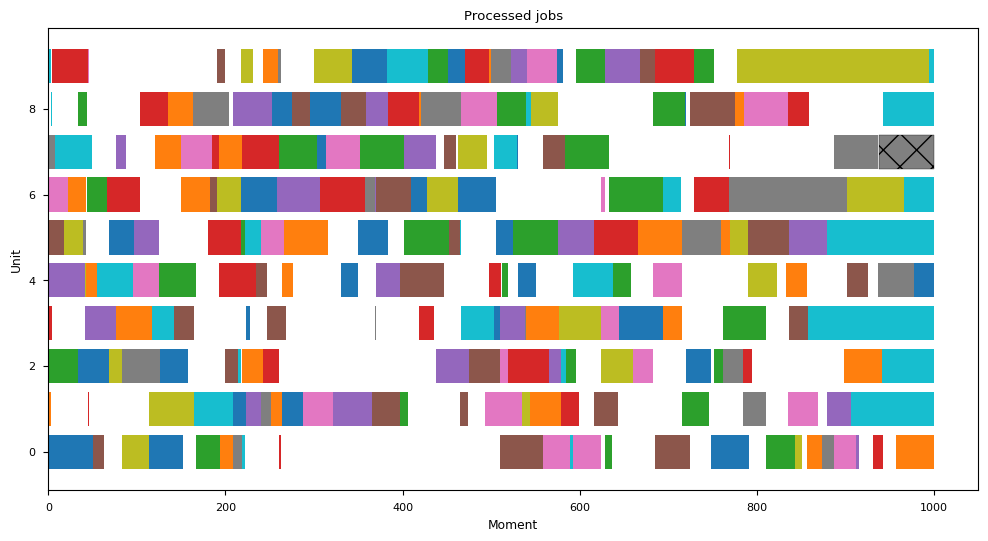

In [347]:
plot_gantt(
    production_logs,
    info=dict(
        window=[0, 1000],
        blocks=[
            dict(
                events=['started_processing', 'finished_processing'],
                style=dict()
            ),
            dict(
                events=['machine_breakdown', 'machine_repair'],
                style=dict(
                    color='gray',
                    edgecolor='black',
                    hatch='\\/'
                )
            )
        ],
        title='Processed jobs',
        xlabel='Moment',
        ylabel='Unit'
    )
);